## Tree Mortality Coding Template: <ENTER SITE NAME>

### Setup

##### This section provides the setup needed to run the subsequent analyses, including:
* Importing the needed packages
* Setting the script and project directory, as well as the workspace environment
* Loading in the necessary datasets. **Note that you will be asked to input the shapefile file path of the region you want to analyze AND the file path for your regional DEM.**

In [59]:
# Import Packages
from pathlib import Path
import arcpy
from arcpy.sa import *
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from scipy.stats import wilcoxon

# Set Script Directory
try:
    script_directory = Path(__file__).resolve().parent
except NameError:
    script_directory = Path.cwd()

# Set Project Root and Data Directory
project_root = script_directory.parent
data_directory = project_root/"Data"

# Set Arcpy Environments
arcpy.env.workspace = str(data_directory)
arcpy.env.overwriteOutput = True

# Load datasets 
polygon_site = input("Input polygon shapefile file path: ")
tree_mortality = Raster(str(data_directory/"Input_Data"/"Tree_Mortality"/"East_Coast_Tree_Mortality.tif"))
inundation_frequency = Raster(str(data_directory/"Input_Data"/"Inundation_Frequency"/"InundFreq_NC_Coast_2017-2024_mosaic.tif"))
land_cover = Raster(str(data_directory/"Input_Data"/"Land_Cover"/"NC_Coastal_Land_Cover_2021_CCAP_J1249552tR0_C0.tif"))
estuary_euclidian_distance = Raster(str(data_directory/"Input_Data"/"Euclidian_Distance"/"coastline_euc_dist.tif"))
artificial_drainage_euclidian_distance = Raster(str(data_directory/"Input_Data"/"Euclidian_Distance"/"artificial_drainage_euc_dist.tif"))
elevation_DEM = input("Input Digital Elevation Model (DEM) file path (.tif): ")

# Create a file path to save your dissolved polygon in the "Dissolved_Polygons" folder within "Output_Data"
dissolved_polygon_site_path = str(data_directory/"Output_Data"/"Dissolved_Polygons"/"dissolved_polygon_site.tif")

# Dissolve your multi-polygon sites into one polygon for analyses
arcpy.management.Dissolve(polygon_site,dissolved_polygon_site_path)

<Result "x:\\Master's_Project\\MP_Data\\Data\\Output_Data\\Dissolved_Polygons\\dissolved_polygon_site.shp">

### Tree Mortality

In [60]:
# Mask tree mortality raster to polygon site
masked_tree_raster = arcpy.sa.ExtractByMask(tree_mortality, polygon_site)

# Save the masked tree raster created using arcpy.sa.ExtractByMask above to the "Tree_Mortalty" folder within "Output_Data"
masked_tree_path = str(data_directory/"Output_Data"/"Tree_Mortality"/"tree_mortality_site_mask.tif")
masked_tree_raster.save(masked_tree_path)

In [61]:
# Use arcpy.Raster to create an arcpy tree mortality raster
tree_mortality_raster = arcpy.Raster(masked_tree_path)

In [62]:
# Create a single-banded raster from the tree mortality raster that solely depicts counts of dead trees/per pixel
arcpy.management.MakeRasterLayer(in_raster=tree_mortality_raster,
                                 out_rasterlayer="tree_count.tif",
                                 where_clause="#",
                                 envelope="#",
                                 band_index="1")

# Create a path to save the single-banded tree mortality raster to the "Tree Mortality" folder within "Output_Data"
dead_tree_count_path = str(data_directory/"Output_Data"/"Tree_Mortality"/"single_band_tree_mortality.tif")

# Copy the resulting raster from the arcpy.management.MakeRasterLayer analysis above and save to the dead_tree_count_path defined above
arcpy.management.CopyRaster(in_raster="tree_count.tif",
                            out_rasterdataset= dead_tree_count_path)

# Use arcpy.Raster to create a single-banded tree raster depicting dead trees/pixel counts for your site of interest
single_band_tree_raster = arcpy.Raster(dead_tree_count_path)

### Inundation Frequency

In [63]:
# Mask inundation frequency raster to polygon site
masked_inundation_raster = arcpy.sa.ExtractByMask(inundation_frequency, polygon_site)

# Save the masked inundation frequency raster created using arcpy.sa.ExtractByMask above to the "Inundation_Frequency" folder within "Output_Data"
masked_inundation_path = str(data_directory/"Output_Data"/"Inundation_Frequency"/"inundation_frequency_site_mask.tif")
masked_inundation_raster.save(masked_inundation_path)

In [64]:
# Use arcpy.Raster to create an arcpy inundation frequency raster for analysis
inundation_frequency_raster = arcpy.Raster(masked_inundation_path) 

#### Live Tree Analysis (Inundation Frequency)

In [65]:
# Create a conditional live tree inundation frequency raster where inundation frequency values are returned in locations where dead trees/pixel is equal to 0, indicating that region of forest is live
live_tree_inundation_raster = Con((single_band_tree_raster == 0), inundation_frequency_raster)

# Save live tree inundation frequency raster to the "Inundation_Frequency" folder within "Output_Data"
live_tree_inundation_raster.save(str(data_directory/"Output_Data"/"Inundation_Frequency"/"live_tree_inundation_raster.tif"))

In [66]:
# Retrieve the median inundation frequency value of live trees within your site of interest
arcpy.sa.ZonalStatisticsAsTable(in_zone_data=dissolved_polygon_site_path,
                                zone_field="FID",
                                in_value_raster=live_tree_inundation_raster,
                                out_table= str(data_directory/"Output_Data"/"Inundation_Frequency"/"zonal_stats_live_tree_inundation.dbf"),
                                ignore_nodata="DATA",
                                statistics_type="MEDIAN")

<Result "x:\\Master's_Project\\MP_Data\\Data\\Output_Data\\Inundation_Frequency\\zonal_stats_live_tree_inundation.dbf">

In [67]:
# Re-list the output table created in the previous code block
live_tree_inundation_table = str(data_directory/"Output_Data"/"Inundation_Frequency/zonal_stats_live_tree_inundation.dbf")

# Create an array from the results of your median inundation frequency value table for live trees
live_tree_inundation_array = arcpy.da.TableToNumPyArray(live_tree_inundation_table, "*")

# Create a Pandas dataframe from the live_tree_inundation_array
df = pd.DataFrame(live_tree_inundation_array)

# Display the MEDIAN column listed in the array, representing the median inundation frequency value of all pixels with only live trees
print(df["MEDIAN"].iloc[0])

0.0945945978165


#### Dead Tree Analysis (Inundation Frequency)

In [68]:
# Create a conditional dead tree inundation frequency raster where inundation frequency values are returned in locations where dead trees/pixel is greater than 0, indicating regions that contain at least one dead tree/pixel
dead_tree_inundation_raster = Con((single_band_tree_raster > 0), inundation_frequency_raster)

# Save dead tree inundation frequency raster to the "Inundation_Frequency" folder within "Output_Data"
dead_tree_inundation_raster.save(str(data_directory/"Output_Data"/"Inundation_Frequency"/"dead_tree_inundation_raster.tif"))

In [69]:
# Retrieve the median inundation frequency value of dead trees within your site of interest (or pixels containing at least one individual dead tree)
arcpy.sa.ZonalStatisticsAsTable(in_zone_data=dissolved_polygon_site_path,
                                zone_field="FID",
                                in_value_raster=dead_tree_inundation_raster,
                                out_table= str(data_directory/"Output_Data"/"Inundation_Frequency"/"zonal_stats_dead_tree_inundation.dbf"),
                                ignore_nodata="DATA",
                                statistics_type="MEDIAN")

<Result "x:\\Master's_Project\\MP_Data\\Data\\Output_Data\\Inundation_Frequency\\zonal_stats_dead_tree_inundation.dbf">

In [70]:
# Re-list the output table created in the previous code block
dead_tree_inundation_table = str(data_directory/"Output_Data"/"Inundation_Frequency"/"zonal_stats_dead_tree_inundation.dbf")

# Create an array from the results of your median inundation frequency value table for dead trees
dead_tree_inundation_array = arcpy.da.TableToNumPyArray(dead_tree_inundation_table, "*")

# Create a Pandas dataframe from the dead_tree_inundation_array
df2 = pd.DataFrame(dead_tree_inundation_array)

# Display the MEDIAN column listed in the array, representing the median inundation frequency value of all pixels with dead trees
print(df2["MEDIAN"].iloc[0])

0.148648649454


#### Median Inundation Frequency by Tree Mortality Bin Class

In [71]:
# Define bin classes for subsequent analyses
tree_threshold_bins = [1,2,3,4,5,7,10,15,25,40,72]

# Compute the maximum number of dead trees/pixel with your site of interest
maximum_tree_value = arcpy.GetRasterProperties_management(single_band_tree_raster,"MAXIMUM").getOutput(0)

# Convert the results of the maximum number of dead trees/pixel to be a floating integer value
maximum_tree_value = int(float(maximum_tree_value))

# Adjust bins to only display up to the maximum number of dead trees within the selected site
adjusted_bins = [b for b in tree_threshold_bins if b < maximum_tree_value]

# Append the adjusted bins to have the maximum bin value be the maximum number of dead trees/pixel within the site of interest
adjusted_bins.append(maximum_tree_value)

# Define the edges to be the appended adjusted bins
edges = adjusted_bins

In [72]:
# Create an empty median inundation frequency list to store median values that correspond to the predefined adjusted bin classes
median_inundation_values = []

# Iterate through the adjusted bins (edges) to calculate the tree mortality and pixel count within each bin class, where lower = the lower threhsold of each bin and upper = the upper threshold of each bin
for i,upper in enumerate(edges):
    lower = 1 if i == 0 else edges [i-1] + 1
    tree_threshold_mask = Con((single_band_tree_raster >= lower) & (single_band_tree_raster <= upper), 1) # create a conditional tree threshold mask that returns tree mortality within each adjusted bin class
    tree_threshold_array = arcpy.RasterToNumPyArray(tree_threshold_mask, nodata_to_value = 0) # create an array from the tree_threshold_mask above and list "No Data" value as 0
    pixel_count = np.count_nonzero(tree_threshold_array) # list the pixel count for dead trees within each adjusted bin class 

# Compute zonal statistics to retrieve median inundation frequency values that correspond to tree mortality within each adjusted bin class
    arcpy.sa.ZonalStatisticsAsTable(
        in_zone_data = tree_threshold_mask,
        zone_field= "Value",
        in_value_raster=inundation_frequency_raster,
        out_table= str(data_directory/"Output_Data"/"Inundation_Frequency"/"zonal_stats_inundation_threshold_gradient.dbf"),
        ignore_nodata="DATA",
        statistics_type="MEDIAN"
        )

# Add median inundation frequency values to empty list by referencing the output table from the above Zonal Statistics as Table analysis
    with arcpy.da.SearchCursor(str(data_directory/"Output_Data"/"Inundation_Frequency"/"zonal_stats_inundation_threshold_gradient.dbf"),["MEDIAN"]) as cursor:
        for row in cursor:
            median_inundation = row[0]
            median_inundation_values.append({
                "Lower Threshold": lower, # lower bin threshold
                "Upper Threshold": upper, # upper bin threshold
                "Pixel Count": pixel_count,
                "Median Inundation Frequency (%)": median_inundation})

# Create a Pandas dataframe containing median inundation frequency values that correspond to each adjusted bin class
inundation_frequency_df = pd.DataFrame(median_inundation_values)

In [73]:
# View the results of the inundation frequency dataframe
inundation_frequency_df

,Lower Threshold,Upper Threshold,Pixel Count,Median Inundation Frequency (%)
0,1,1,4148,0.128378
1,2,2,1700,0.135135
2,3,3,856,0.155405
3,4,4,528,0.182432
4,5,5,373,0.195946
5,6,7,449,0.216216
6,8,10,393,0.250000
7,11,15,321,0.317568
8,16,25,210,0.358108
9,26,40,66,0.391892


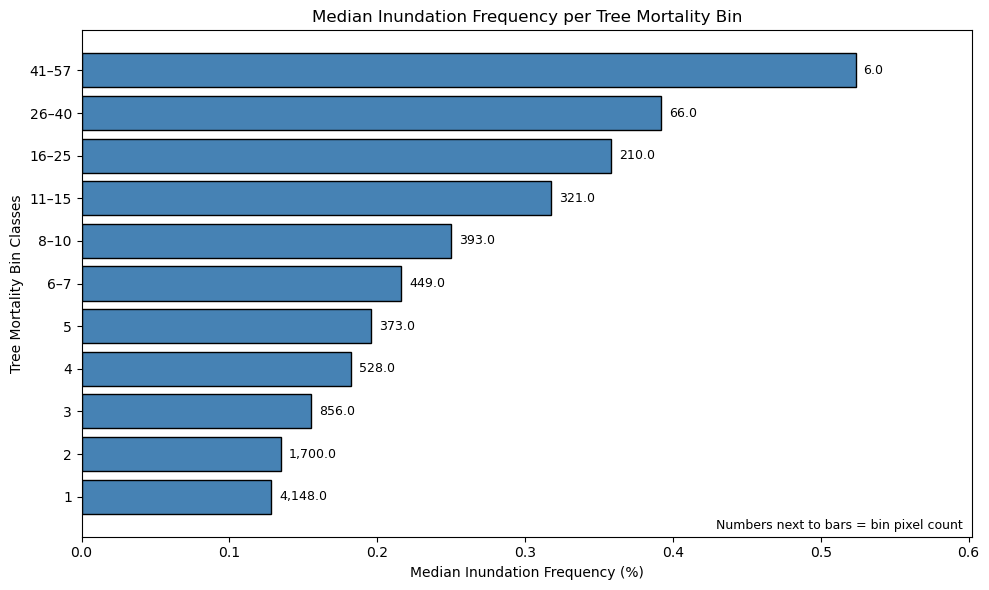

In [74]:
# Create labels for plot
inund_x = np.arange(len(inundation_frequency_df))
inund_y_median = inundation_frequency_df["Median Inundation Frequency (%)"].astype(float)
inund_y_count = inundation_frequency_df["Pixel Count"].astype(float)

# Define dash mark for bin labels
en_dash = "\u2013"

# Create Bin Label column for display
inundation_frequency_df["Bin Label"] = np.where(
    inundation_frequency_df["Lower Threshold"] == inundation_frequency_df["Upper Threshold"],
    inundation_frequency_df["Lower Threshold"].astype(int).astype(str),
    inundation_frequency_df["Lower Threshold"].astype(int).astype(str)
    + en_dash +
    inundation_frequency_df["Upper Threshold"].astype(int).astype(str)
)

# Create figure, axes, and bars
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(inund_x, inund_y_median, color="steelblue", edgecolor="black")

# Set maximum x-axis limit
xmax = inund_y_median.max()
ax.set_xlim(0, xmax * 1.15)

# Plot labels and formatting
ax.set_yticks(inund_x)
ax.set_yticklabels(inundation_frequency_df["Bin Label"])
ax.set_xlabel("Median Inundation Frequency (%)")
ax.set_ylabel("Tree Mortality Bin Classes")
ax.set_title("Median Inundation Frequency per Tree Mortality Bin")
ax.text(
    0.99, 0.01,
    "Numbers next to bars = bin pixel count",
    transform=ax.transAxes,
    ha="right",
    va="bottom",
    fontsize=9,
    color="black"
)

# Add pixel counts to the right of each bar
for i, (val, cnt) in enumerate(zip(inund_y_median, inund_y_count)):
    ax.text(val + (inund_y_median.max()*0.01),  # small offset to the right
            i,
            f"{cnt:,}",
            va="center",
            fontsize=9)

# Plot and save figure
plt.tight_layout()
plt.savefig(
    str(data_directory/"Output_Data"/"Figure_Outputs"/"inundation_frequency.png"),
    bbox_inches="tight"
)
plt.show()

### Land Cover

In [75]:
# Mask land cover data to polygon site
masked_landcover_raster = arcpy.sa.ExtractByMask(land_cover,polygon_site)

# Save the masked land cover raster created using arcpy.sa.ExtractByMask above to the "Land_Cover" folder within "Output_Data"
masked_landcover_path = str(data_directory/"Output_Data"/"Land_Cover"/"land_cover_site_mask.tif")
masked_landcover_raster.save(masked_landcover_path)

In [76]:
# Use arcpy.Raster to create an arcpy land cover raster for analysis
landcover_raster = arcpy.Raster(masked_landcover_path)

#### Dead Tree Analysis (Land Cover)

In [77]:
# Create a masked raster for dead trees
dead_tree_mask = Con((single_band_tree_raster > 0), single_band_tree_raster)
dead_tree_mask.save(str(data_directory/"Output_Data"/"Land_Cover"/"dead_tree_mask.tif"))

In [78]:
# Retrieve the sum of total number of dead trees per land cover class
arcpy.sa.ZonalStatisticsAsTable(in_zone_data=masked_landcover_path,
                                zone_field="LABELS",
                                in_value_raster=dead_tree_mask,
                                out_table=str(data_directory/"Output_Data"/"Land_Cover"/"zonal_stats_dead_tree_landcover.dbf"),
                                ignore_nodata="DATA",
                                statistics_type="SUM")

<Result "x:\\Master's_Project\\MP_Data\\Data\\Output_Data\\Land_Cover\\zonal_stats_dead_tree_landcover.dbf">

In [79]:
# Create an array for tree mortality per land cover class using the table output from the previous Zonal Statistics as Table tool
dead_tree_landcover_table = str(data_directory/"Output_Data"/"Land_Cover"/"zonal_stats_dead_tree_landcover.dbf")
dead_tree_landcover_array = arcpy.da.TableToNumPyArray(dead_tree_landcover_table, "*")
df3 = pd.DataFrame(dead_tree_landcover_array)

In [80]:
# Create landcover subclasses
landcover_subset_class = [
    "Deciduous Forest",
    "Evergreen Forest"
    "Mixed Forest",
    "Scrub/Shrub",
    "Palustrine Forested Wetland",
    "Palustrine Scrub/Shrub Wetland",
    "Estuarine Forested Wetland",
    "Estuarine Scrub/Shrub Wetland"
    ]

# Create a new dead tree subset dataframe from our dead tree landcover dataframe to only display classes of interest
landcover_subset_dead_df = df3[df3["LABELS"].isin(landcover_subset_class)]

# Rename the "LABELS", "SUM", and "AREA" columns for better readability
landcover_subset_dead_df = landcover_subset_dead_df.rename(columns={"LABELS":"Land Cover Class","SUM": "Total Dead Trees", "AREA":"Dead Tree Area (m^2)"})
print(landcover_subset_dead_df[['Land Cover Class','Total Dead Trees','Dead Tree Area (m^2)']])

                  Land Cover Class  Total Dead Trees  Dead Tree Area (m^2)
3                 Deciduous Forest               1.0                 900.0
6                      Scrub/Shrub             270.0              121500.0
7      Palustrine Forested Wetland           13207.0             2796300.0
8   Palustrine Scrub/Shrub Wetland            8302.0             2013300.0
10   Estuarine Scrub/Shrub Wetland             698.0              213300.0


#### Area Percentage Analysis

In [81]:
# Create a masked raster for live trees
live_tree_mask = Con((single_band_tree_raster == 0), single_band_tree_raster)
live_tree_mask.save(str(data_directory/"Output_Data"/"Land_Cover"/"live_tree_mask.tif"))

In [82]:
# Retrieve the sum of total number of live trees per land cover class
arcpy.sa.ZonalStatisticsAsTable(in_zone_data=masked_landcover_path,
                                zone_field="LABELS",
                                in_value_raster=live_tree_mask,
                                out_table=str(data_directory/"Output_Data"/"Land_Cover"/"zonal_stats_live_tree_landcover.dbf"),
                                ignore_nodata="DATA",
                                statistics_type="SUM")

<Result "x:\\Master's_Project\\MP_Data\\Data\\Output_Data\\Land_Cover\\zonal_stats_live_tree_landcover.dbf">

In [83]:
# Create an array for live forest per land cover class using the table output from the previous Zonal Statistics as Table tool
live_tree_landcover_table = str(data_directory/"Output_Data"/"Land_Cover"/"zonal_stats_live_tree_landcover.dbf")
live_tree_landcover_array = arcpy.da.TableToNumPyArray(live_tree_landcover_table, "*")
df4 = pd.DataFrame(live_tree_landcover_array)

In [84]:
# Create a new live tree subset dataframe from our live tree landcover dataframe to only display classes of interest
landcover_subset_live_df = df4[df4["LABELS"].isin(landcover_subset_class)]

# Rename the "LABELS" and "SUM" columns for better readability
landcover_subset_live_df = landcover_subset_live_df.rename(columns={"LABELS":"Land Cover Class","AREA":"Live Tree Area (m^2)"})
print(landcover_subset_live_df[['Land Cover Class','Live Tree Area (m^2)']])

                  Land Cover Class  Live Tree Area (m^2)
4                 Deciduous Forest               18000.0
7                      Scrub/Shrub              601200.0
8      Palustrine Forested Wetland             3825900.0
9   Palustrine Scrub/Shrub Wetland             2615400.0
11   Estuarine Scrub/Shrub Wetland              158400.0


In [85]:
# Remove duplicate column names if they exist
landcover_subset_live_df = landcover_subset_live_df.loc[:, ~landcover_subset_live_df.columns.duplicated()]

# Join live tree and dead tree subset dataframes
landcover_subset_dead_df = landcover_subset_dead_df.merge(
    landcover_subset_live_df[["Land Cover Class","Live Tree Area (m^2)"]],
    on="Land Cover Class",
    how="left"
)

In [86]:
# Calculate percentage of land cover class experiencing mortality
landcover_subset_dead_df["% Experiencing Mortality"] = (
    landcover_subset_dead_df["Dead Tree Area (m^2)"] /
    (landcover_subset_dead_df["Live Tree Area (m^2)"] + landcover_subset_dead_df["Dead Tree Area (m^2)"])
) * 100

# Display final table results
print(landcover_subset_dead_df[['Land Cover Class','Total Dead Trees','Dead Tree Area (m^2)','Live Tree Area (m^2)','% Experiencing Mortality']])

# Export final land cover table to CSV
landcover_subset_dead_df.to_csv(str(data_directory/"Output_Data"/"Figure_Outputs"/"land_cover_site_summary.csv"))


                 Land Cover Class  Total Dead Trees  Dead Tree Area (m^2)  \
0                Deciduous Forest               1.0                 900.0   
1                     Scrub/Shrub             270.0              121500.0   
2     Palustrine Forested Wetland           13207.0             2796300.0   
3  Palustrine Scrub/Shrub Wetland            8302.0             2013300.0   
4   Estuarine Scrub/Shrub Wetland             698.0              213300.0   

   Live Tree Area (m^2)  % Experiencing Mortality  
0               18000.0                  4.761905  
1              601200.0                 16.811955  
2             3825900.0                 42.226148  
3             2615400.0                 43.496014  
4              158400.0                 57.384988  


### Distance to Estuary

In [87]:
# Create reference for NAD 1983 UTM Zone 17N projected coordinate system
utm_epsg = arcpy.SpatialReference(26917)

# Convert tree raster to NAD 1983 UTM Zone 17N
tree_raster_utm = arcpy.ProjectRaster_management(in_raster=single_band_tree_raster,
                         out_raster=str(data_directory/"Output_Data"/"Distance_to_Coast"/"tree_raster_utm.tif"),
                         out_coor_system=utm_epsg)

#### Dead Tree Analysis (Distance to Estuary)

In [88]:
# Create conditional raster for distances of dead trees to estuary
dead_tree_estuary_distance = Con(Raster(tree_raster_utm)> 0, estuary_euclidian_distance)

# Save dead tree estuary distance raster to the "Distance_to_Coast" folder within "Output_Data"
dead_tree_estuary_distance.save(str(data_directory/"Output_Data"/"Distance_to_Coast"/"dead_tree_estuary_distance_raster.tif"))

In [89]:
# Use zonal statistics to calculate the median distance to the estuarine coastline for all dead trees
arcpy.sa.ZonalStatisticsAsTable(
        in_zone_data = dissolved_polygon_site_path,
        zone_field= "FID",
        in_value_raster= dead_tree_estuary_distance,
        out_table= str(data_directory/"Output_Data"/"Distance_to_Coast"/"zonal_stats_dead_tree_estuary_distance.dbf"),
        ignore_nodata="DATA",
        statistics_type="MEDIAN"
    )

<Result "x:\\Master's_Project\\MP_Data\\Data\\Output_Data\\Distance_to_Coast\\zonal_stats_dead_tree_estuary_distance.dbf">

In [90]:
# Re-list the output table created in the previous code block
dead_tree_est_dist_table = str(data_directory/"Output_Data"/"Distance_to_Coast"/"zonal_stats_dead_tree_estuary_distance.dbf")

# Create an array from the results of your median distance to estuarine coastline value table for dead trees
dead_tree_est_dist_array = arcpy.da.TableToNumPyArray(dead_tree_est_dist_table, "*")

# Create a Pandas dataframe from the dead_tree_est_dist_array
df5 = pd.DataFrame(dead_tree_est_dist_array)

# Display the MEDIAN column listed in the array, representing the median distance to the estuarine coastline for all pixels with dead trees
print(df5["MEDIAN"].iloc[0])

402.492248535


#### Live Tree Analysis (Distance to Estuary)

In [91]:
# Create conditional raster for distances of live trees to coast
live_tree_estuary_distance = Con(Raster(tree_raster_utm) == 0, estuary_euclidian_distance)

# Save live tree estuary distance raster to the "Distance_to_Coast" folder within "Output_Data"
live_tree_estuary_distance.save(str(data_directory/"Output_Data"/"Distance_to_Coast"/"live_tree_distance_raster.tif"))

In [92]:
# Use zonal statistics to calculate the median distance to the estuarine coastline for all live trees
arcpy.sa.ZonalStatisticsAsTable(
        in_zone_data = dissolved_polygon_site_path,
        zone_field= "FID",
        in_value_raster= live_tree_estuary_distance,
        out_table= str(data_directory/"Output_Data"/"Distance_to_Coast"/"zonal_stats_live_tree_distance.dbf"),
        ignore_nodata="DATA",
        statistics_type="MEDIAN"
    )

<Result "x:\\Master's_Project\\MP_Data\\Data\\Output_Data\\Distance_to_Coast\\zonal_stats_live_tree_distance.dbf">

In [93]:
# Re-list the output table created in the previous code block
live_tree_est_dist_table = str(data_directory/"Output_Data"/"Distance_to_Coast"/"zonal_stats_live_tree_distance.dbf")

# Create an array from the results of your median distance to estuarine coastline value table for live trees
live_tree_est_dist_array = arcpy.da.TableToNumPyArray(live_tree_est_dist_table, "*")

# Create a Pandas dataframe from the live_tree_est_dist_array
df6 = pd.DataFrame(live_tree_est_dist_array)

# Display the MEDIAN column listed in the array, representing the median distance to the estuarine coastline for all pixels with only live trees
print(df6["MEDIAN"].iloc[0])

342.052612305


#### Median Distance to Estuary by Tree Mortality Bin Class

In [94]:
# Create an empty median distance to estuary list to store median values that correspond to the predefined adjusted bin classes
median_est_distances = []

# Iterate through the adjusted bins (edges) to calculate the tree mortality and pixel count within each bin class, where lower = the lower threhsold of each bin and upper = the upper threshold of each bin
for i,upper in enumerate(edges):
    lower = 1 if i == 0 else edges [i-1] + 1
    tree_threshold_mask = Con((single_band_tree_raster >= lower) & (single_band_tree_raster <= upper), 1) # create a conditional tree threshold mask that returns tree mortality within each adjusted bin class
    tree_threshold_array = arcpy.RasterToNumPyArray(tree_threshold_mask, nodata_to_value = 0) # create an array from the tree_threshold_mask above and list "No Data" value as 0
    pixel_count = np.count_nonzero(tree_threshold_array) # list the pixel count for dead trees within each adjusted bin class

# Compute zonal statistics to retrieve median distance to estuarine coastline values that correspond to tree mortality within each adjusted bin class
    arcpy.sa.ZonalStatisticsAsTable(
        in_zone_data = tree_threshold_mask,
        zone_field= "Value",
        in_value_raster=estuary_euclidian_distance,
        out_table= str(data_directory/"Output_Data"/"Distance_to_Coast"/"zonal_stats_euclidian_distance_estuary_gradient.dbf"),
        ignore_nodata="DATA",
        statistics_type="MEDIAN"
    )

# Add median distance to estuary values to empty list by referencing the output table from the above Zonal Statistics as Table analysis
    with arcpy.da.SearchCursor(str(data_directory/"Output_Data"/"Distance_to_Coast"/"zonal_stats_euclidian_distance_estuary_gradient.dbf"),["MEDIAN"]) as cursor:
        for row in cursor:
            median_est_dist = row[0]
            median_est_distances.append({
                "Lower Threshold": lower,
                "Upper Threshold": upper,
                "Pixel Count": pixel_count,
                "Median Distance (m)": median_est_dist})

# Create a Pandas dataframe containing median distance to estuarine coastline values that correspond to each adjusted bin class
distance_coast_df = pd.DataFrame(median_est_distances)

In [95]:
# View the results of the distance to coast dataframe
distance_coast_df

,Lower Threshold,Upper Threshold,Pixel Count,Median Distance (m)
0,1,1,4148,420.000000
1,2,2,1700,331.360840
2,3,3,856,305.941162
3,4,4,528,300.748138
4,5,5,373,362.491394
5,6,7,449,384.187469
6,8,10,393,547.448608
7,11,15,321,699.714233
8,16,25,210,765.734436
9,26,40,66,873.354645


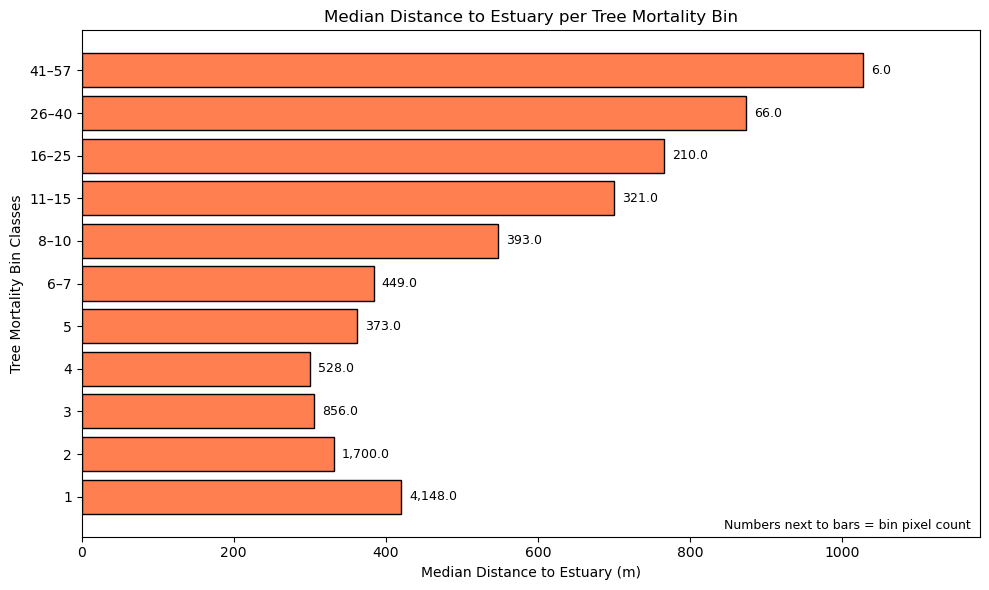

In [96]:
# Create labels for plot
est_dist_x = np.arange(len(distance_coast_df))
est_dist_y_median = distance_coast_df["Median Distance (m)"].astype(float)
est_dist_y_count = distance_coast_df["Pixel Count"].astype(float)

# Create Bin Label column for display
distance_coast_df["Bin Label"] = np.where(
    distance_coast_df["Lower Threshold"] == distance_coast_df["Upper Threshold"],
    distance_coast_df["Lower Threshold"].astype(int).astype(str),
    distance_coast_df["Lower Threshold"].astype(int).astype(str)
    + en_dash +
    distance_coast_df["Upper Threshold"].astype(int).astype(str)
)

# Create figure, axes, and bars
fig2, ax2 = plt.subplots(figsize=(10, 6))
bars2 = ax2.barh(est_dist_x, est_dist_y_median, color="coral", edgecolor="black")

# Set maximum x-axis limit
xmax = est_dist_y_median.max()
ax2.set_xlim(0, xmax * 1.15)

# Plot labels and formatting
ax2.set_yticks(est_dist_x)
ax2.set_yticklabels(distance_coast_df["Bin Label"])
ax2.set_xlabel("Median Distance to Estuary (m)")
ax2.set_ylabel("Tree Mortality Bin Classes")
ax2.set_title("Median Distance to Estuary per Tree Mortality Bin")
ax2.text(
    0.99, 0.01,
    "Numbers next to bars = bin pixel count",
    transform=ax2.transAxes,
    ha="right",
    va="bottom",
    fontsize=9,
    color="black"
)

# Add pixel counts to the right of each bar
for i, (val, cnt) in enumerate(zip(est_dist_y_median, est_dist_y_count)):
    ax2.text(val + (est_dist_y_median.max()*0.01),  # small offset to the right
            i,
            f"{cnt:,}",
            va="center",
            fontsize=9)

# Plot and save figure
plt.tight_layout()
plt.savefig(
    str(data_directory/"Output_Data"/"Figure_Outputs"/"distance_to_coast.png"),
    bbox_inches="tight"
)
plt.show()

### Distance to Artificial Drainage Network

#### Dead Tree Analysis (Distance to Artificial Network)

In [97]:
# Create conditional raster for distances of dead trees to artificial drainage network
dead_tree_adn_distance = Con(Raster(tree_raster_utm)> 0, artificial_drainage_euclidian_distance)

# Save dead tree artificial drainage raster to the "Distance_to_ADN" folder within "Output_Data"
dead_tree_adn_distance.save(str(data_directory/"Output_Data"/"Distance_to_ADN"/"dead_tree_adn_distance.tif"))

In [98]:
# Use zonal statistics to calculate the median distance to artificial drainage network for all dead trees
arcpy.sa.ZonalStatisticsAsTable(
        in_zone_data = dissolved_polygon_site_path,
        zone_field= "FID",
        in_value_raster= dead_tree_adn_distance,
        out_table= str(data_directory/"Output_Data"/"Distance_to_ADN"/"zonal_stats_dead_tree_adn_distance.dbf"),
        ignore_nodata="DATA",
        statistics_type="MEDIAN"
    )

<Result "x:\\Master's_Project\\MP_Data\\Data\\Output_Data\\Distance_to_ADN\\zonal_stats_dead_tree_adn_distance.dbf">

In [99]:
# Re-list the output table created in the previous code block
dead_tree_adn_dist_table = str(data_directory/"Output_Data"/"Distance_to_ADN"/"zonal_stats_dead_tree_adn_distance.dbf")

# Create an array from the results of your median distance to artificial drainage value table for dead trees
dead_tree_adn_dist_array = arcpy.da.TableToNumPyArray(dead_tree_adn_dist_table, "*")

# Create a Pandas dataframe from the dead_tree_adn_dist_array
df7 = pd.DataFrame(dead_tree_adn_dist_array)

# Display the MEDIAN column listed in the array, representing the median distance to an artificial drainage network for all pixels containing dead trees
print(df7["MEDIAN"].iloc[0])

690.0


#### Live Tree Analysis (Distance to Artifiical Drainage Network)

In [100]:
# Create conditional raster for distances of live trees to artificial drainage network
live_tree_adn_distance= Con(Raster(tree_raster_utm)== 0, artificial_drainage_euclidian_distance)

# Save live tree artificial drainage raster to the "Distance_to_ADN" folder within "Output_Data"
live_tree_adn_distance.save(str(data_directory/"Output_Data"/"Distance_to_ADN"/"live_tree_adn_distance.tif"))

In [101]:
# Use zonal statistics to calculate the median distance to artificial drainage network for all live trees
arcpy.sa.ZonalStatisticsAsTable(
        in_zone_data = dissolved_polygon_site_path,
        zone_field= "FID",
        in_value_raster= live_tree_adn_distance,
        out_table= str(data_directory/"Output_Data"/"Distance_to_ADN"/"zonal_stats_live_tree_adn_distance.dbf"),
        ignore_nodata="DATA",
        statistics_type="MEDIAN"
    )

<Result "x:\\Master's_Project\\MP_Data\\Data\\Output_Data\\Distance_to_ADN\\zonal_stats_live_tree_adn_distance.dbf">

In [102]:
# Re-list the output table created in the previous code block
live_tree_adn_dist_table = str(data_directory/"Output_Data"/"Distance_to_ADN"/"zonal_stats_live_tree_adn_distance.dbf")

# Create an array from the results of your median distance to artificial drainage value table for live trees
live_tree_adn_dist_array = arcpy.da.TableToNumPyArray(live_tree_adn_dist_table, "*")

# Create a Pandas dataframe from the live_tree_adn_dist_array
df8 = pd.DataFrame(live_tree_adn_dist_array)

# Display the MEDIAN column listed in the array, representing the median distance to an artificial drainage network for all pixels with only live trees
print(df8["MEDIAN"].iloc[0])

700.357055664


#### Median Distance to Artificial Drainage Network by Tree Mortality Bin Class

In [103]:
# Create an empty median distance to artificial drainage network list to store median values that correspond to the predefined adjusted bin classes
median_adn_distances = []

# Iterate through the adjusted bins (edges) to calculate the tree mortality and pixel count within each bin class, where lower = the lower threhsold of each bin and upper = the upper threshold of each bin
for i,upper in enumerate(edges):
    lower = 1 if i == 0 else edges [i-1] + 1
    tree_threshold_mask = Con((single_band_tree_raster >= lower) & (single_band_tree_raster <= upper), 1) # create a conditional tree threshold mask that returns tree mortality within each adjusted bin class
    tree_threshold_array = arcpy.RasterToNumPyArray(tree_threshold_mask, nodata_to_value = 0) # create an array from the tree_threshold_mask above and list "No Data" value as 0
    pixel_count = np.count_nonzero(tree_threshold_array) # list the pixel count for dead trees within each adjusted bin class

# Compute zonal statistics to retrieve median distance to artificial drainage network values that correspond to tree mortality within each adjusted bin class
    arcpy.sa.ZonalStatisticsAsTable(
        in_zone_data = tree_threshold_mask,
        zone_field= "Value",
        in_value_raster=artificial_drainage_euclidian_distance,
        out_table= str(data_directory/"Output_Data"/"Distance_to_ADN"/"zonal_stats_euclidian_distance_adn_gradient.dbf"),
        ignore_nodata="DATA",
        statistics_type="MEDIAN"
    )

# Add median distance to artificial drainage network values to empty list by referencing the output table from the above Zonal Statistics as Table analysis
    with arcpy.da.SearchCursor(str(data_directory/"Output_Data"/"Distance_to_ADN"/"zonal_stats_euclidian_distance_adn_gradient.dbf"),["MEDIAN"]) as cursor:
        for row in cursor:
            median_adn_dist = row[0]
            median_adn_distances.append({
                "Lower Threshold": lower,
                "Upper Threshold": upper,
                "Pixel Count": pixel_count,
                "Median Distance (m)": median_adn_dist
                })
            
# Create a Pandas dataframe containing median distance to artificial drainage values that correspond to each adjusted bin class
distance_adn_df = pd.DataFrame(median_adn_distances)

In [104]:
# View the results of the distance to artificial drainage network dataframe
distance_adn_df

,Lower Threshold,Upper Threshold,Pixel Count,Median Distance (m)
0,1,1,4148,690.000000
1,2,2,1700,684.105225
2,3,3,856,668.464233
3,4,4,528,655.209900
4,5,5,373,600.749512
5,6,7,449,660.000000
6,8,10,393,708.025452
7,11,15,321,740.945312
8,16,25,210,780.574768
9,26,40,66,738.202179


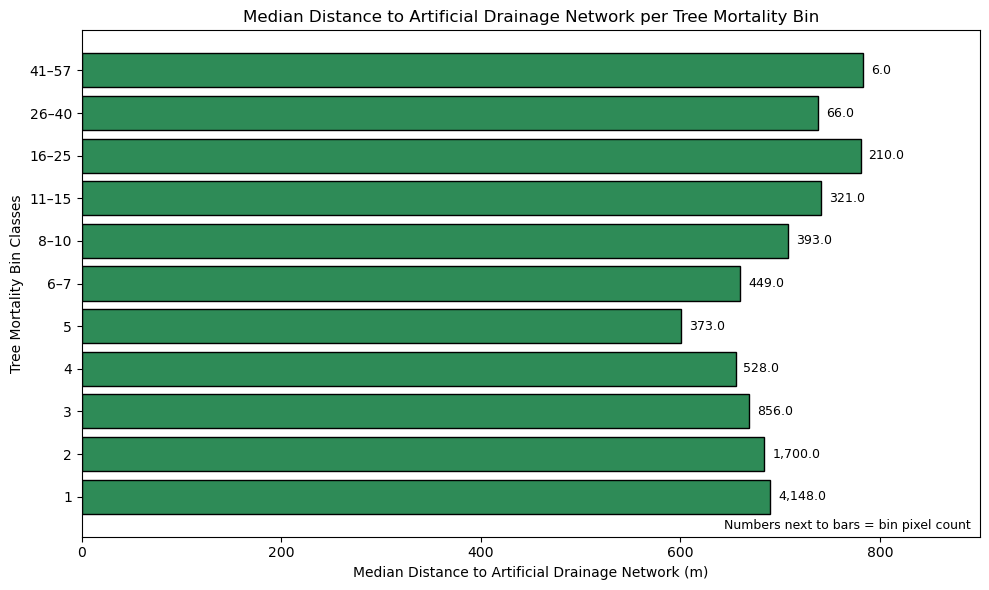

In [105]:
# Create labels for plot
adn_dist_x = np.arange(len(distance_adn_df))
adn_dist_y_median = distance_adn_df["Median Distance (m)"].astype(float)
adn_dist_y_count = distance_adn_df["Pixel Count"].astype(float)

# Create Bin Label column for display
distance_adn_df["Bin Label"] = np.where(
    distance_adn_df["Lower Threshold"] == distance_adn_df["Upper Threshold"],
    distance_adn_df["Lower Threshold"].astype(int).astype(str),
    distance_adn_df["Lower Threshold"].astype(int).astype(str)
    + en_dash +
    distance_adn_df["Upper Threshold"].astype(int).astype(str)
)

# Create figure, axes, and bars
fig3, ax3 = plt.subplots(figsize=(10, 6))
bars3 = ax3.barh(adn_dist_x, adn_dist_y_median, color="seagreen", edgecolor="black")

# Set maximum x-axis limit
xmax = adn_dist_y_median.max()
ax3.set_xlim(0, xmax * 1.15)

# Plot labels and formatting
ax3.set_yticks(adn_dist_x)
ax3.set_yticklabels(distance_adn_df["Bin Label"])
ax3.set_xlabel("Median Distance to Artificial Drainage Network (m)")
ax3.set_ylabel("Tree Mortality Bin Classes")
ax3.set_title("Median Distance to Artificial Drainage Network per Tree Mortality Bin")
ax3.text(
    0.99, 0.01,
    "Numbers next to bars = bin pixel count",
    transform=ax3.transAxes,
    ha="right",
    va="bottom",
    fontsize=9,
    color="black"
)

# Add pixel counts to the right of each bar
for i, (val, cnt) in enumerate(zip(adn_dist_y_median, adn_dist_y_count)):
    ax3.text(val + (adn_dist_y_median.max()*0.01),  # small offset to the right
            i,
            f"{cnt:,}",
            va="center",
            fontsize=9)

# Plot and save figure
plt.tight_layout()
plt.savefig(
    str(data_directory/"Output_Data"/"Figure_Outputs"/"distance_to_adn.png"),
    bbox_inches="tight"
)
plt.show()

### Elevation

In [106]:
# Use arcpy.Raster to create an arcpy DEM raster for analysis
elevation_raster = arcpy.Raster(elevation_DEM)

#### Live Tree Analysis (Elevation)

In [107]:
# Create a live tree elevation raster
live_tree_elevation_raster = Con((single_band_tree_raster == 0), elevation_raster)

# Save live tree elevation raster to the "Elevation" folder within "Output_Data"
live_tree_elevation_raster.save(str(data_directory/"Output_Data"/"Elevation"/"live_tree_elevation_raster.tif"))

In [108]:
# Retrieve median elevation value of live trees
arcpy.sa.ZonalStatisticsAsTable(in_zone_data=dissolved_polygon_site_path,
                                zone_field="FID",
                                in_value_raster=live_tree_elevation_raster,
                                out_table= str(data_directory/"Output_Data"/"Elevation"/"zonal_stats_live_tree_elevation.dbf"),
                                ignore_nodata="DATA",
                                statistics_type="MEDIAN")

<Result "x:\\Master's_Project\\MP_Data\\Data\\Output_Data\\Elevation\\zonal_stats_live_tree_elevation.dbf">

In [109]:
# Re-list the output table created in the previous code block
live_tree_elevation_table = str(data_directory/"Output_Data"/"Elevation"/"zonal_stats_live_tree_elevation.dbf")

# Create an array from the results of your median elevation value table for live trees
live_tree_elevation_array = arcpy.da.TableToNumPyArray(live_tree_elevation_table, "*")

# Create a Pandas dataframe from the live_tree_elevation_array
df9 = pd.DataFrame(live_tree_elevation_array)

# Display the MEDIAN column listed in the array, representing the median elevation for all pixels with only live trees
print(df9["MEDIAN"].iloc[0])

0.758952021599


#### Dead Tree Analysis (Elevation)

In [110]:
# Create a dead tree elevation raster
dead_tree_elevation_raster = Con((single_band_tree_raster > 0), elevation_raster)

# Save dead tree elevation raster to the "Elevation" folder within "Output_Data"
dead_tree_elevation_raster.save(str(data_directory/"Output_Data"/"Elevation"/"dead_tree_elevation_raster.tif"))

In [111]:
# Retrieve median elevation value of dead trees
arcpy.sa.ZonalStatisticsAsTable(in_zone_data=dissolved_polygon_site_path,
                                zone_field="FID",
                                in_value_raster=dead_tree_elevation_raster,
                                out_table= str(data_directory/"Output_Data"/"Elevation"/"zonal_stats_dead_tree_elevation.dbf"),
                                ignore_nodata="DATA",
                                statistics_type="MEDIAN")

<Result "x:\\Master's_Project\\MP_Data\\Data\\Output_Data\\Elevation\\zonal_stats_dead_tree_elevation.dbf">

In [112]:
# Re-list the output table created in the previous code block
dead_tree_elevation_table = str(data_directory/"Output_Data"/"Elevation"/"zonal_stats_dead_tree_elevation.dbf")

# Create an array from the results of your median elevation value table for dead trees
dead_tree_elevation_array = arcpy.da.TableToNumPyArray(dead_tree_elevation_table, "*")

# Create a Pandas dataframe from the dead_tree_elevation_array
df10 = pd.DataFrame(dead_tree_elevation_array)

# Display the MEDIAN column listed in the array, representing the median elevation for all pixels containing dead trees
print(df10["MEDIAN"].iloc[0])

0.548640012741


#### Median Elevation by Tree Mortality Bin Class

In [113]:
# Create an empty median elevation list to store median values that correspond to the predefined adjusted bin classes
median_elevation_values = []

# Iterate through the adjusted bins (edges) to calculate the tree mortality and pixel count within each bin class, where lower = the lower threhsold of each bin and upper = the upper threshold of each bin
for i,upper in enumerate(edges):
    lower = 1 if i == 0 else edges [i-1] + 1
    tree_threshold_mask = Con((single_band_tree_raster >= lower) & (single_band_tree_raster <= upper), 1) # create a conditional tree threshold mask that returns tree mortality within each adjusted bin class
    tree_threshold_array = arcpy.RasterToNumPyArray(tree_threshold_mask, nodata_to_value = 0) # create an array from the tree_threshold_mask above and list "No Data" value as 0
    pixel_count = np.count_nonzero(tree_threshold_array) # list the pixel count for dead trees within each adjusted bin class

# Compute zonal statistics to retrieve median elevation values that correspond to tree mortality within each adjusted bin class
    arcpy.sa.ZonalStatisticsAsTable(
        in_zone_data = tree_threshold_mask,
        zone_field= "Value",
        in_value_raster=elevation_raster,
        out_table= str(data_directory/"Output_Data"/"Elevation"/"zonal_stats_elevation_gradient.dbf"),
        ignore_nodata="DATA",
        statistics_type="MEDIAN"
    )

# Add median elevation values to empty list by referencing the output table from the above Zonal Statistics as Table analysis
    with arcpy.da.SearchCursor(str(data_directory/"Output_Data"/"Elevation"/"zonal_stats_elevation_gradient.dbf"),["MEDIAN"]) as cursor:
        for row in cursor:
            median_elevation = row[0]
            median_elevation_values.append({
                "Lower Threshold": lower,
                "Upper Threshold": upper,
                "Pixel Count": pixel_count,
                "Median Elevation (m)": median_elevation})

# Create a Pandas dataframe containing median elevation values that correspond to each adjusted bin class
elevation_df = pd.DataFrame(median_elevation_values)

In [114]:
# View the results of the elevation dataframe
elevation_df

,Lower Threshold,Upper Threshold,Pixel Count,Median Elevation (m)
0,1,1,4148,0.688848
1,2,2,1700,0.533400
2,3,3,856,0.490728
3,4,4,528,0.460248
4,5,5,373,0.466344
5,6,7,449,0.438912
6,8,10,393,0.426720
7,11,15,321,0.429768
8,16,25,210,0.451104
9,26,40,66,0.477012


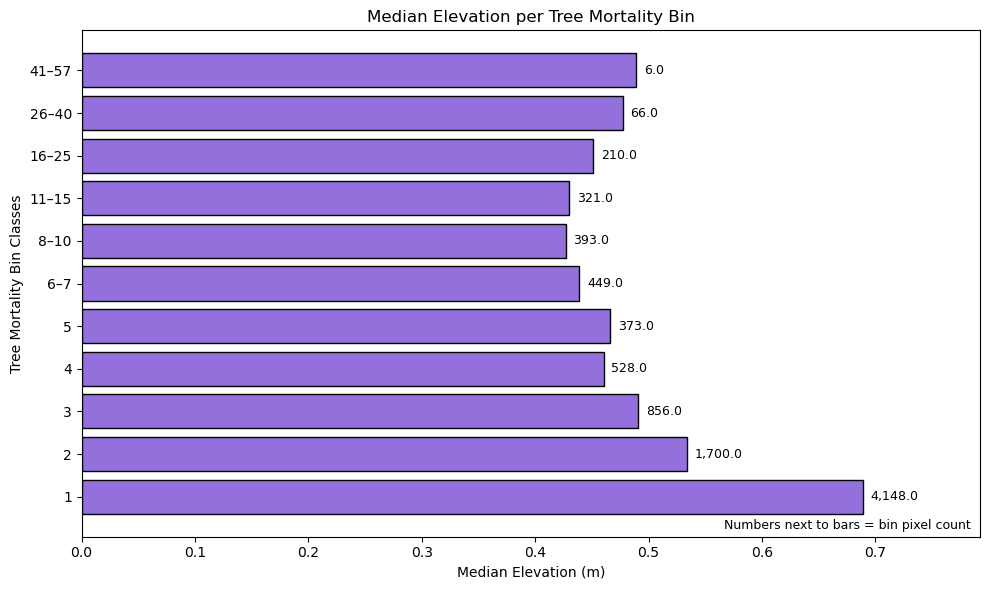

In [115]:
# Create labels for plot
elev_x = np.arange(len(elevation_df))
elev_y_median = elevation_df["Median Elevation (m)"].astype(float)
elev_y_count = elevation_df["Pixel Count"].astype(float)

# Create Bin Label column for display
elevation_df["Bin Label"] = np.where(
    elevation_df["Lower Threshold"] == elevation_df["Upper Threshold"],
    elevation_df["Lower Threshold"].astype(int).astype(str),
    elevation_df["Lower Threshold"].astype(int).astype(str)
    + en_dash +
    elevation_df["Upper Threshold"].astype(int).astype(str)
)

# Create figure, axes, and bars
fig4, ax4 = plt.subplots(figsize=(10, 6))
bars4 = ax4.barh(elev_x, elev_y_median, color="mediumpurple", edgecolor="black")

# Set maximum x-axis limit
xmax = elev_y_median.max()
ax4.set_xlim(0, xmax * 1.15)

# Plot labels and formatting
ax4.set_yticks(elev_x)
ax4.set_yticklabels(elevation_df["Bin Label"])
ax4.set_xlabel("Median Elevation (m)")
ax4.set_ylabel("Tree Mortality Bin Classes")
ax4.set_title("Median Elevation per Tree Mortality Bin")
ax4.text(
    0.99, 0.01,
    "Numbers next to bars = bin pixel count",
    transform=ax4.transAxes,
    ha="right",
    va="bottom",
    fontsize=9,
    color="black"
)

# Add pixel counts to the right of each bar
for i, (val, cnt) in enumerate(zip(elev_y_median, elev_y_count)):
    ax4.text(val + (elev_y_median.max()*0.01),  # small offset to the right
            i,
            f"{cnt:,}",
            va="center",
            fontsize=9)

# Plot and save figure
plt.tight_layout()
plt.savefig(
    str(data_directory/"Output_Data"/"Figure_Outputs"/"elevation.png"),
    bbox_inches="tight"
)
plt.show()

### Final Live vs. Dead Tree Analysis

#### Creating Final Live vs. Dead Tree Summary Dataframe

In [116]:
# Create final live tree dictionary from previously created Pandas dataframes
live_tree_data = {
    "Median Inundation Frequency (%)": df["MEDIAN"].iloc[0],
    "Median Distance to Estuary (m)": df6["MEDIAN"].iloc[0],
    "Median Distance to Artificial Drainage (m)": df8["MEDIAN"].iloc[0],
    "Median Elevation (m)": df9["MEDIAN"].iloc[0]
}

# Create final dead tree dictionary from previously created Pandas dataframes
dead_tree_data = {
    "Median Inundation Frequency (%)": df2["MEDIAN"].iloc[0],
    "Median Distance to Estuary (m)": df5["MEDIAN"].iloc[0],
    "Median Distance to Artificial Drainage (m)": df7["MEDIAN"].iloc[0],
    "Median Elevation (m)": df10["MEDIAN"].iloc[0]
}

# Create a live vs. dead tree summary dataframe from above dictionaries
tree_summary_df = pd.DataFrame.from_dict(
    {
        "Live": live_tree_data,
        "Dead": dead_tree_data
    },
    orient = "columns"
)

# Print final summary dataframe and save to CSV file
print(tree_summary_df)
tree_summary_df.to_csv(str(data_directory/"Output_Data"/"Figure_Outputs"/"live_versus_dead_site_summary.csv"))

                                                  Live        Dead
Median Inundation Frequency (%)               0.094595    0.148649
Median Distance to Estuary (m)              342.052612  402.492249
Median Distance to Artificial Drainage (m)  700.357056  690.000000
Median Elevation (m)                          0.758952    0.548640


#### Statistics and Probability Density Function (PDF) Analyses